<a href="https://colab.research.google.com/github/Ahmed-M-Elshazly/Homework-7/blob/main/Homework_7_Problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Homework 2
#Problem2_VGG_Cifar100
#Ahmed Elshazly
#801420724

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, f1_score
import time
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F

In [ ]:
# Set device
torch.cuda.empty_cache()
device1 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load CIFAR-10 dataset to calculate mean and std
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)
val_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
len(val_dataset)

10000

In [ ]:
img, label = train_dataset[100]

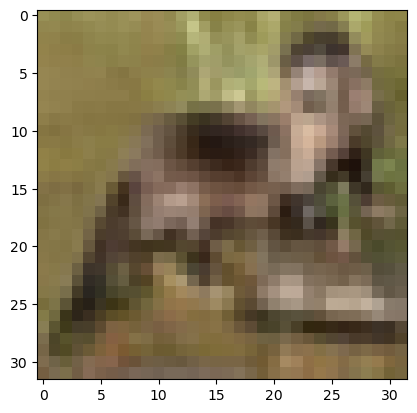

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [ ]:
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=False,
                          transform=transforms.ToTensor())
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

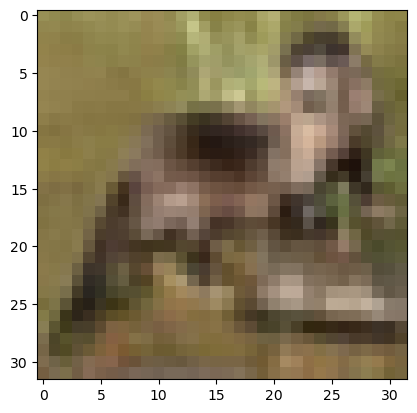

In [ ]:
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [ ]:
train_mean=imgs.view(3, -1).mean(dim=1)
train_std=imgs.view(3, -1).std(dim=1)
print(train_mean)
print(train_std)


tensor([0.5071, 0.4865, 0.4409])
tensor([0.2673, 0.2564, 0.2762])


In [ ]:
transforms.Normalize(train_mean, train_std)


Normalize(mean=tensor([0.5071, 0.4865, 0.4409]), std=tensor([0.2673, 0.2564, 0.2762]))

In [ ]:
transformed_train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(train_mean,
                             train_std)
    ]))
train_loader = torch.utils.data.DataLoader(transformed_train_dataset, batch_size=128, shuffle=True)

In [ ]:
class VGG(nn.Module):
    def __init__(self, num_classes=100):
        super(VGG, self).__init__()
        layers = []
        in_channels = 3
        cfg = [64 ,'M', 128,'M', 256, 256,'M']


        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v

        self.features = nn.Sequential(*layers)


        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4,512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


model = VGG(num_classes=100).to(device1)

In [ ]:
val_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=False,
                          transform=transforms.ToTensor())

In [ ]:
imgs = torch.stack([img_t for img_t, _ in val_dataset], dim=3)
imgs.shape

torch.Size([3, 32, 32, 10000])

In [ ]:
val_mean=imgs.view(3, -1).mean(dim=1)
val_std=imgs.view(3, -1).std(dim=1)
print(val_mean)
print(val_std)


tensor([0.5088, 0.4874, 0.4419])
tensor([0.2683, 0.2574, 0.2771])


In [ ]:
transforms.Normalize(val_mean, val_std)

Normalize(mean=tensor([0.5088, 0.4874, 0.4419]), std=tensor([0.2683, 0.2574, 0.2771]))

In [ ]:
transformed_val_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(train_mean,
                             train_std)
    ]))
val_loader = torch.utils.data.DataLoader(transformed_val_dataset, batch_size=128, shuffle=False)

Epoch: 1, Train Loss: 4.605977, Val_Loss:4.605473, Runtime: 11.16 seconds, Train Accurracy : 0.010000, Validation Accuracy : 0.010000
Epoch: 2, Train Loss: 4.605358, Val_Loss:4.604852, Runtime: 10.87 seconds, Train Accurracy : 0.010000, Validation Accuracy : 0.009900
Epoch: 3, Train Loss: 4.604662, Val_Loss:4.604114, Runtime: 10.91 seconds, Train Accurracy : 0.009953, Validation Accuracy : 0.009767
Epoch: 4, Train Loss: 4.603776, Val_Loss:4.603064, Runtime: 10.95 seconds, Train Accurracy : 0.010005, Validation Accuracy : 0.009850
Epoch: 5, Train Loss: 4.602463, Val_Loss:4.601388, Runtime: 10.80 seconds, Train Accurracy : 0.010096, Validation Accuracy : 0.009960
Epoch: 6, Train Loss: 4.600024, Val_Loss:4.597914, Runtime: 10.81 seconds, Train Accurracy : 0.010177, Validation Accuracy : 0.009967
Epoch: 7, Train Loss: 4.593729, Val_Loss:4.586854, Runtime: 10.86 seconds, Train Accurracy : 0.010969, Validation Accuracy : 0.010857
Epoch: 8, Train Loss: 4.565360, Val_Loss:4.524749, Runtime: 10

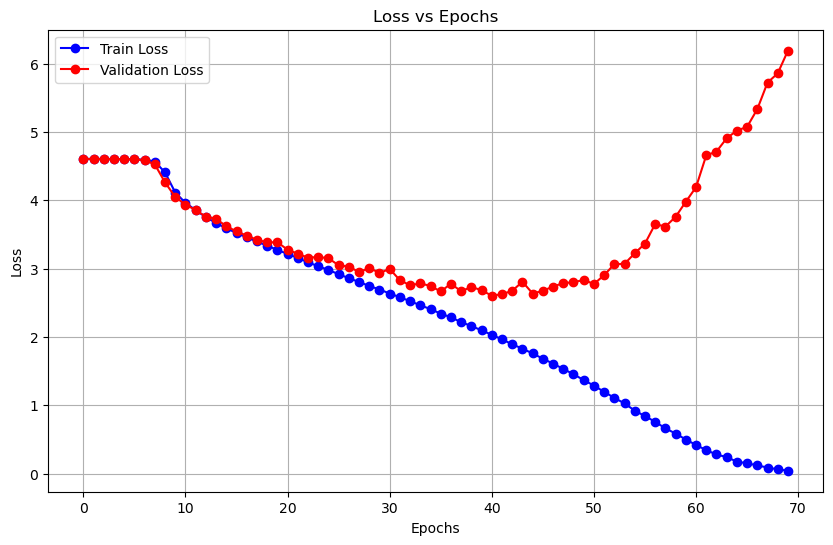

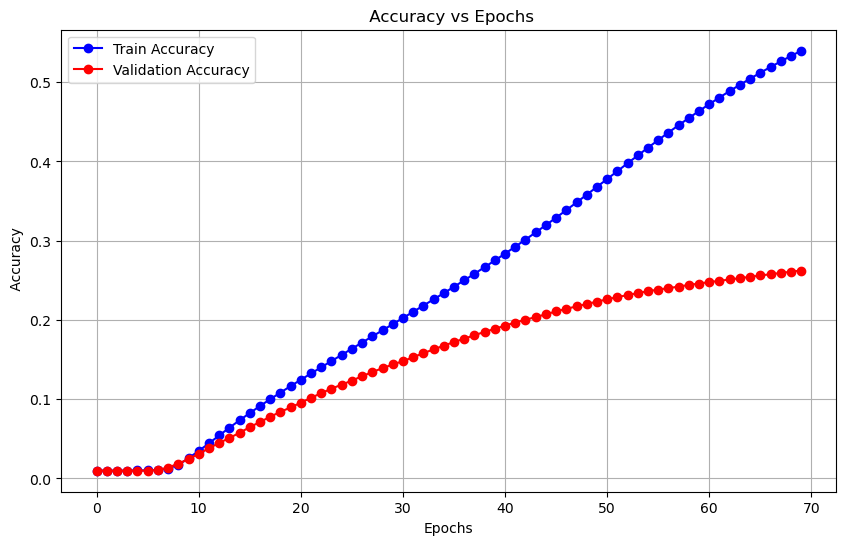

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epochs = 70
total_start_time = time.time()
losses=[]
val_losses=[]
train_accs=[]
val_accs=[]
tr_correct=0
tr_total=0
val_correct=0
val_total=0

for epoch in range(num_epochs):
    start_time = time.time()
    counter=0
    cum_loss=0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device1), labels.to(device1)
        batch_size=imgs.shape[0]
        outputs=model(imgs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        outputs=model(imgs)
        _,predicted=torch.max(outputs,dim=1)
        tr_total+=labels.shape[0]
        tr_correct+=int((predicted==labels).sum())
        counter+=1
        cum_loss+=loss

    tr_acc=tr_correct/tr_total
    epoch_loss=cum_loss/counter

    counter_val=0
    cum_loss_val=0
    for imgs, labels in val_loader:
      imgs, labels = imgs.to(device1), labels.to(device1)
      batch_size=imgs.shape[0]
      with torch.no_grad():
        outputs = model(imgs)
        val_loss = loss_fn(outputs, labels)
      _,predicted=torch.max(outputs,dim=1)
      val_total+=labels.shape[0]
      val_correct+=int((predicted==labels).sum())
      counter_val+=1
      cum_loss_val+=val_loss

    val_acc=val_correct/val_total
    epoch_val_loss=cum_loss_val/counter_val



    end_time = time.time()
    training_time = end_time - start_time
    print(f"Epoch: {epoch+1}, Train Loss: {float(epoch_loss):.6f}, Val_Loss:{float(epoch_val_loss):.6f}, Runtime: {training_time:.2f} seconds, Train Accurracy : {float(tr_acc):.6f}, Validation Accuracy : {float(val_acc):.6f}")
    losses.append(float(epoch_loss))
    val_losses.append(float(epoch_val_loss))
    train_accs.append(float(tr_acc))
    val_accs.append(float(val_acc))

total_end_time = time.time()
total_training_time = total_end_time - total_start_time
print(f'Total Training Time: {total_training_time:.2f} seconds')
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), losses, marker='o', linestyle='-', color='b',label='Train Loss')
plt.plot(range(num_epochs), val_losses, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


# Plotting train accur vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_accs, marker='o', linestyle='-', color='b',label='Train Accuracy')
plt.plot(range(num_epochs), val_accs, marker='o', linestyle='-', color='r',label='Validation Accuracy')
plt.title(" Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel(" Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def get_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

In [ ]:
total_params, trainable_params = get_model_size(model)
print(f"  Total parameters: {total_params}")
print(f"  Trainable parameters: {trainable_params}")

  Total parameters: 3137124
  Trainable parameters: 3137124


In [ ]:
torch.save(model, "saved_model.pth")
print("Full model saved as 'saved_model.pth'")


torch.save(model.state_dict(), "saved_weights.pth")
print("Model weights saved as 'saved_weights.pth'")

Full model saved as 'saved_model.pth'
Model weights saved as 'saved_weights.pth'
